# First Model

The idea is to create a first model as quick as possible. This will give not the best results,
but allows to iterate fast and deliver already a prototypic API later on.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Markdown
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as me
import category_encoders as ce

In [2]:
data = pd.read_csv('../data/bank-additional-full.csv', sep=';')

In [3]:
# the data information says, that duration should not be used, since it
# is only available after the marketing call
data = data.drop(columns=['duration'])

In [4]:
data['y'] = data['y'].map({'no': 0, 'yes': 1})

## train - test  split

Before starting to train the model the data is split into a train and a test set.
There is a lot wrong with this simple appraoch here, but the model we build firstly will be thrown away anyways.
In a later phase one has to correct this in two (and a half) ways:
* we need a speparate set for the model validation and hyperparameter optimization
* due to the low number of positive cases, one should use a startified split, such that
  each set has enough positive samples
* the total number of samples is not too high, so for validation a KFold approach would be advantageous

In [5]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

As as little as possible time should go into the model building, the categorical variables are one-hot encoded.

In [6]:
cat_cols = train.dtypes[train.dtypes == 'object'].index

In [7]:
enc = ce.OneHotEncoder(return_df=True, cols=cat_cols, drop_invariant=True)

In [8]:
train = enc.fit_transform(train)
test = enc.transform(test)

/home/marenz/miniconda3/envs/model2cloud/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [9]:
x_train = train.drop(columns=['y'])
y_train = train['y']
x_test = test.drop(columns=['y'])
y_test = test['y']

In [10]:
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    max_depth=10,
)

In [11]:
clf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200)

## Performance metrics

As above, not details or exhausive work here. Just as fast as possible to something which is not total nonsense.
Speaking of total nonsense, using the accuracy here would be total nonsense due to the class imbalance.
However, for now the balanced accuracy is used as the next best thing. Although, not the best metric
for this task.

In [12]:
pred_train = clf.predict(x_train)
pred_test = clf.predict(x_test)

In [13]:
Markdown(
f"""
Balanced accuracy on the training data {me.balanced_accuracy_score(y_train, pred_train):.3f}

Balanced accuracy on the test data {me.balanced_accuracy_score(y_test, pred_test):.3f}

Using a plain RandomForestClassifier where only the max_depth is restircted to 10,
there overfitting is ~~ok~~ not too bad.

Honestly, also the confusion matrix and the precision-recall curve looks quite nice.
Much better than I would have expected. Usually, these tasks are a little bit harder.
""")


Balanced accuracy on the training data 0.760

Balanced accuracy on the test data 0.734

Using a plain RandomForestClassifier where only the max_depth is restircted to 10,
there overfitting is ~~ok~~ not too bad.

Honestly, also the confusion matrix and the precision-recall curve looks quite nice.
Much better than I would have expected. Usually, these tasks are a little bit harder.


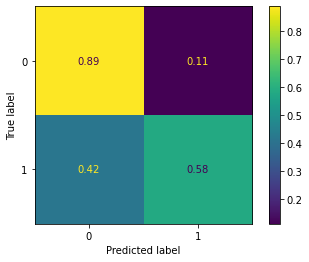

In [14]:
me.plot_confusion_matrix(clf, x_test, y_test, normalize='true')

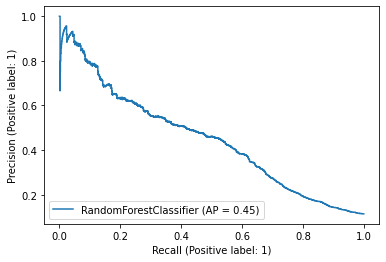

In [15]:
me.plot_precision_recall_curve(clf, x_test, y_test)

## Final Training

Finally, the model is trained on the full dataset and stored in a pickle file.

In [16]:
x = data.drop(columns=['y'])
y = data['y']

x = enc.fit_transform(x, y)
clf.fit(x, y)

/home/marenz/miniconda3/envs/model2cloud/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200)

In [17]:
import pickle
from pathlib import Path

In [18]:
model_dir = Path('../app/model/')
model_dir.mkdir(exist_ok=True, parents=True)

In [19]:
with open(model_dir / 'simple_enc.pkl', 'wb') as handle:
    pickle.dump(enc, handle)
    
with open(model_dir / 'simple_rf.pkl', 'wb') as handle:
    pickle.dump(clf, handle)